# Extracting and Plotting Stats from rRNA and Primer Extension Data

## Sample Comparison statistics

### Compute per position KS-tests

$F_{n}(x)={1 \over n}\sum _{i=1}^{n}I_{[-\infty ,x]}(X_{i})$  
$D_{n}=\sup _{x}|F_{n}(x)-F(x)|$

* Code used to generate KS tests for each position
    * note: return_stat = True
    
```
def compute_ks_tests(samp_base_levels, ctrl_base_levels, return_stat):
    def compute_pos_ks_test(pos_samp_levels, pos_ctrl_levels):
        """Compute effect size statistic or p-value of two-sample
        Kolmogorov-Smirnov test

        Using definition from
        https://github.com/scipy/scipy/blob/v0.14.0/scipy/stats/stats.py#L3886
        """
        samp_n, ctrl_n = pos_samp_levels.shape[0], pos_ctrl_levels.shape[0]
        pos_all_levels = np.concatenate([pos_samp_levels, pos_ctrl_levels])
        samp_cdf = np.searchsorted(
            pos_samp_levels, pos_all_levels, side='right') / samp_n
        ctrl_cdf = np.searchsorted(
            pos_ctrl_levels, pos_all_levels, side='right') / ctrl_n
        d = np.max(np.absolute(samp_cdf - ctrl_cdf))
        if return_stat:
            # subtract 1 so most significant are smallest values
            return 1 - d
        en = np.sqrt(samp_n * ctrl_n / float(samp_n + ctrl_n))
        return stats.distributions.kstwobign.sf((en + 0.12 + 0.11 / en) * d)


    samp_valid_indices = np.logical_not(np.isnan(samp_base_levels))
    ctrl_valid_indices = np.logical_not(np.isnan(ctrl_base_levels))
    return np.array([compute_pos_ks_test(
        np.sort(pos_samp_levels[samp_valid_indices[i]]),
        np.sort(pos_ctrl_levels[ctrl_valid_indices[i]]))
                     for i, (pos_samp_levels, pos_ctrl_levels) in enumerate(zip(
                             samp_base_levels, ctrl_base_levels))])
 ```
### Compute Window Mean

* window size = $w$  
$WindowMean_j = \frac{\sum _{i=j-w}^{j+w}D_i}{w}$


* Code used to calculate window mean 
    * window length = 1 on each side (lag = 1)
    
 ```
 def calc_window_means(stats, lag):
    """Compute mean over a moving window across a set of statistics
    """
    assert lag > 0, 'Invalid window provided.'
    width = (lag * 2) + 1
    if stats.shape[-1] < width:
        raise th.TomboError(
            "Statistics vector too short for window mean compuation.")
    m_stats = np.empty(stats.shape)
    m_stats[:] = np.NAN
    m_stats[...,lag:-lag] = np.mean(np.lib.stride_tricks.as_strided(
        stats, shape=stats.shape[:-1] + (stats.shape[-1] - width + 1, width),
        strides=stats.strides + (stats.strides[-1],)), -1)

    return m_stats
```

In [1]:
# Tombo library
from tombo import tombo_helper, tombo_stats, resquiggle
# matplotlib library
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# numpy library
import numpy as np
# built in library
import os


## Primer Extension
Here we just filter out positions that are not common amongst all reads

In [2]:
HOME = "/Users/andrewbailey/CLionProjects/personal/projects" 

In [3]:
# set some defaults 
ref_seq = "GAATTGGGCCCGCTCAGCAGACACAGAGCCTGAGCATCGCCGCGGAC"
max_position = 48

b_vs_t = os.path.join(HOME, "tombo_supplemental/primer_extension/sample_compare/BrdU_vs_T.level_compare_sample.tombo.stats")
e_vs_t = os.path.join(HOME, "tombo_supplemental/primer_extension/sample_compare/EdU_vs_T.level_compare_sample.tombo.stats")
f_vs_t = os.path.join(HOME, "tombo_supplemental/primer_extension/sample_compare/FdU_vs_T.level_compare_sample.tombo.stats")
i_vs_t = os.path.join(HOME, "tombo_supplemental/primer_extension/sample_compare/IdU_vs_T.level_compare_sample.tombo.stats")

brdu_top_pos_file = os.path.join(HOME, "tombo_supplemental/primer_extension/sample_compare/BrdU_vs_T.top_positions.tsv")
edu_top_pos_file = os.path.join(HOME, "tombo_supplemental/primer_extension/sample_compare/EdU_vs_T.top_positions.tsv")
fdu_top_pos_file = os.path.join(HOME, "tombo_supplemental/primer_extension/sample_compare/FdU_vs_T.top_positions.tsv")
idu_top_pos_file = os.path.join(HOME, "tombo_supplemental/primer_extension/sample_compare/IdU_vs_T.top_positions.tsv")



In [4]:
def write_top_positions(stats_file, output_file, max_position):
    """Write the sorted all per position stats from a tombo stats file 
    
    :param stats_file: patht to tombo stats file
    :param output_file: path to output tsv file
    :param max_position: max reference position to write
    """
    assert os.path.exists(stats_file)
    with open(output_file, "w") as fh:
        ts = tombo_stats.TomboStats(stats_file)
        for contig in ts:
            if contig[0] == "primer_extension" and contig[1] == "+":
                all_data = contig[4][contig[4]["pos"] < max_position]
                all_data.sort()
                print("\t".join(["D-statistic", "ref_pos", "cov", "control_cov"]), file=fh)
                for x in all_data:
                    print("\t".join([str(y) for y in x]), file=fh)

        

In [5]:
write_top_positions(b_vs_t, brdu_top_pos_file, max_position=max_position)
write_top_positions(e_vs_t, edu_top_pos_file, max_position=max_position)
write_top_positions(f_vs_t, fdu_top_pos_file, max_position=max_position)
write_top_positions(i_vs_t, idu_top_pos_file, max_position=max_position)

<IPython.core.display.Javascript object>


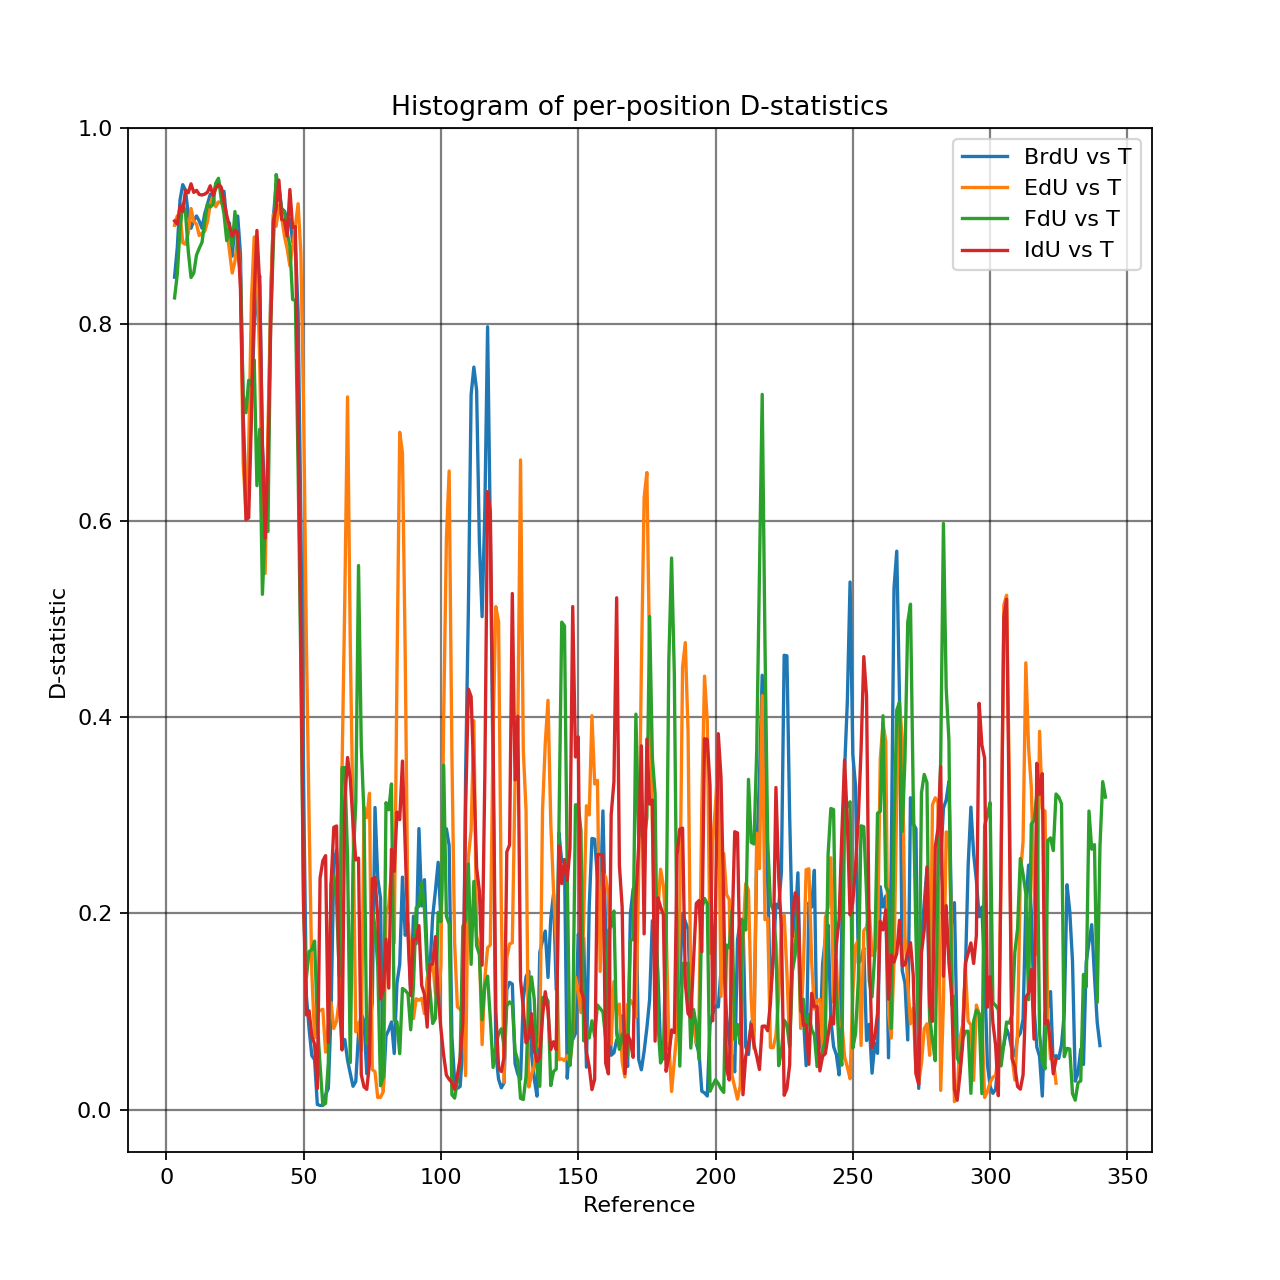

In [46]:
%matplotlib notebook

stats_files = [b_vs_t, e_vs_t, f_vs_t, i_vs_t]
labels = ["BrdU vs T", "EdU vs T", "FdU vs T", "IdU vs T"]
save_fig_path = None

title = "Histogram of per-position D-statistics"
y_label = "Reference"

fig = plt.figure(figsize=(8, 8))
panel1 = plt.axes([0.1, 0.1, .8, .8])
panel1.set_xlabel("Reference")
panel1.set_ylabel("D-statistic")
panel1.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)

panel1.set_title(label=title)

for i in range(len(stats_files)):
    assert os.path.exists(stats_files[i])
    ts = tombo_stats.TomboStats(stats_files[i])
    for contig in ts:
        if contig[0] == "primer_extension" and contig[1] == "+":
            all_data = contig[4]
            panel1.plot([x[1] for x in all_data], [x[0] for x in all_data], label=labels[i])

panel1.legend()

# option to save figure or just show it
if save_fig_path is not None:
    plt.savefig(save_fig_path)


<IPython.core.display.Javascript object>


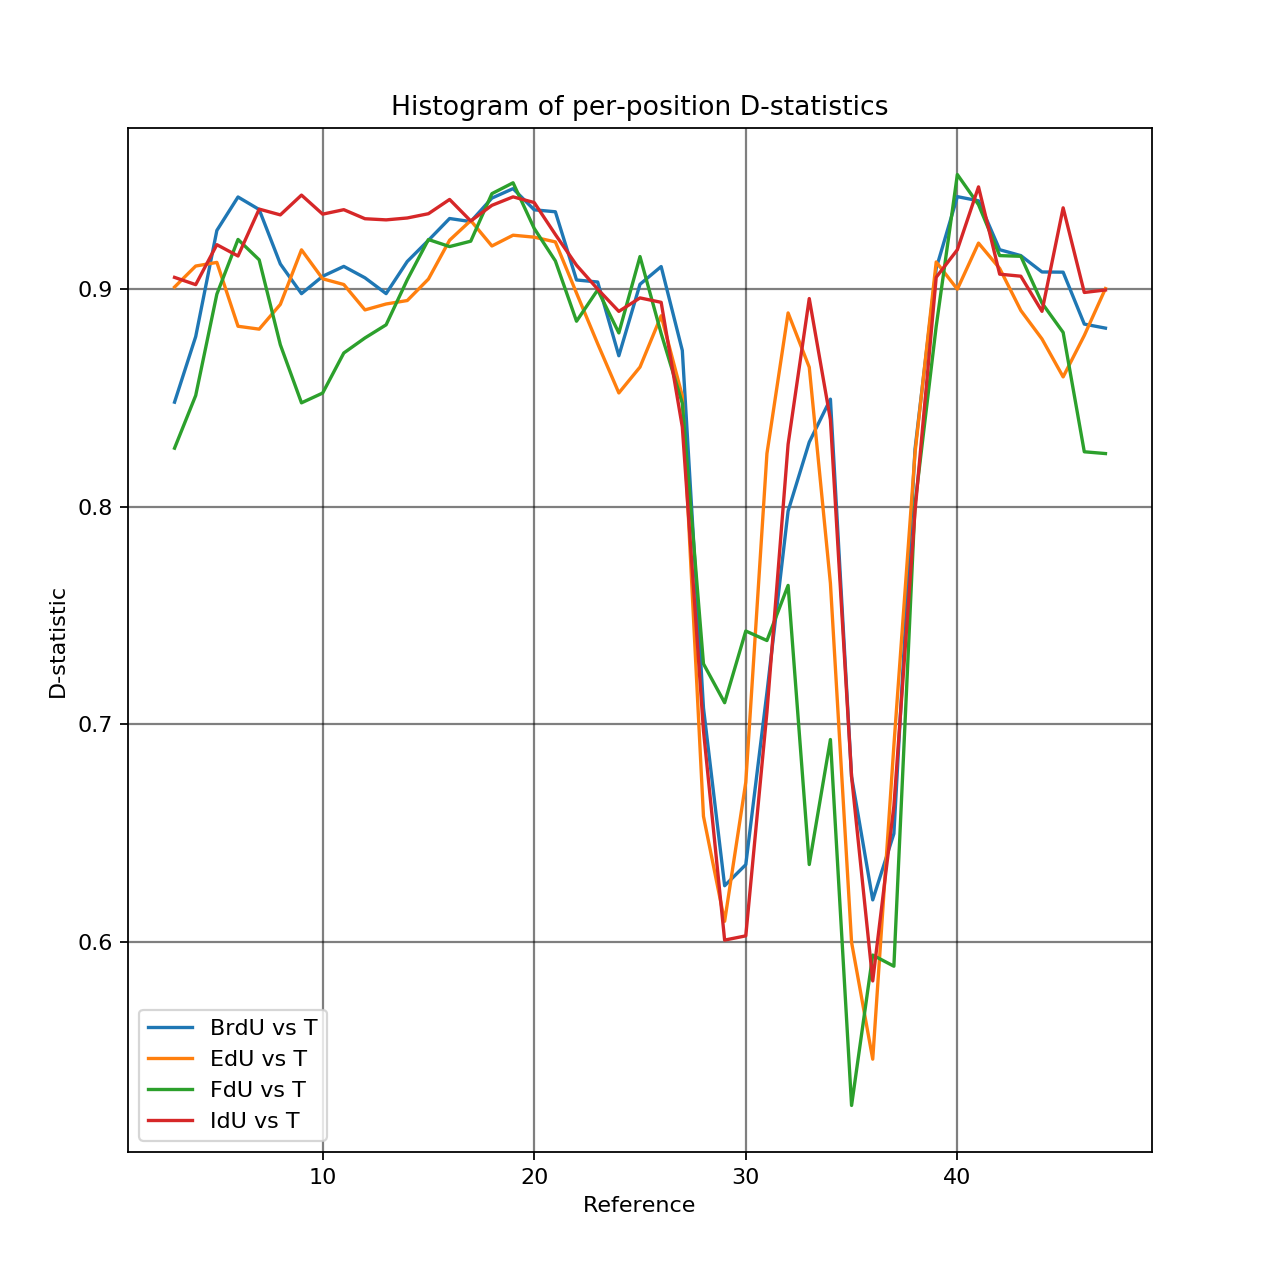

In [48]:
%matplotlib notebook

stats_files = [b_vs_t, e_vs_t, f_vs_t, i_vs_t]
labels = ["BrdU vs T", "EdU vs T", "FdU vs T", "IdU vs T"]
save_fig_path = None

title = "Histogram of per-position D-statistics"
y_label = "Reference"

fig = plt.figure(figsize=(8, 8))
panel1 = plt.axes([0.1, 0.1, .8, .8])
panel1.set_xlabel("Reference")
panel1.set_ylabel("D-statistic")
panel1.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)

panel1.set_title(label=title)

for i in range(len(stats_files)):
    assert os.path.exists(stats_files[i])
    ts = tombo_stats.TomboStats(stats_files[i])
    for contig in ts:
        if contig[0] == "primer_extension" and contig[1] == "+":
            all_data = contig[4][contig[4]["pos"] < max_position]
            panel1.plot([x[1] for x in all_data], [x[0] for x in all_data], label=labels[i])

panel1.legend()

# option to save figure or just show it
if save_fig_path is not None:
    plt.savefig(save_fig_path)


## rRNA


In [49]:

HOME = "/Users/andrewbailey/CLionProjects/personal/projects" 

m7g_vs_native = os.path.join(HOME, "tombo_supplemental/rRNA/native_vs_m7G.level_compare_sample.tombo.stats")
psi_vs_native = os.path.join(HOME, "tombo_supplemental/rRNA/native_vs_psi.level_compare_sample.tombo.stats")

m7g_top_pos_file = os.path.join(HOME, "tombo_supplemental/primer_extension/sample_compare/BrdU_vs_T.top_positions.tsv")
psi_top_pos_file = os.path.join(HOME, "tombo_supplemental/primer_extension/sample_compare/EdU_vs_T.top_positions.tsv")


<IPython.core.display.Javascript object>


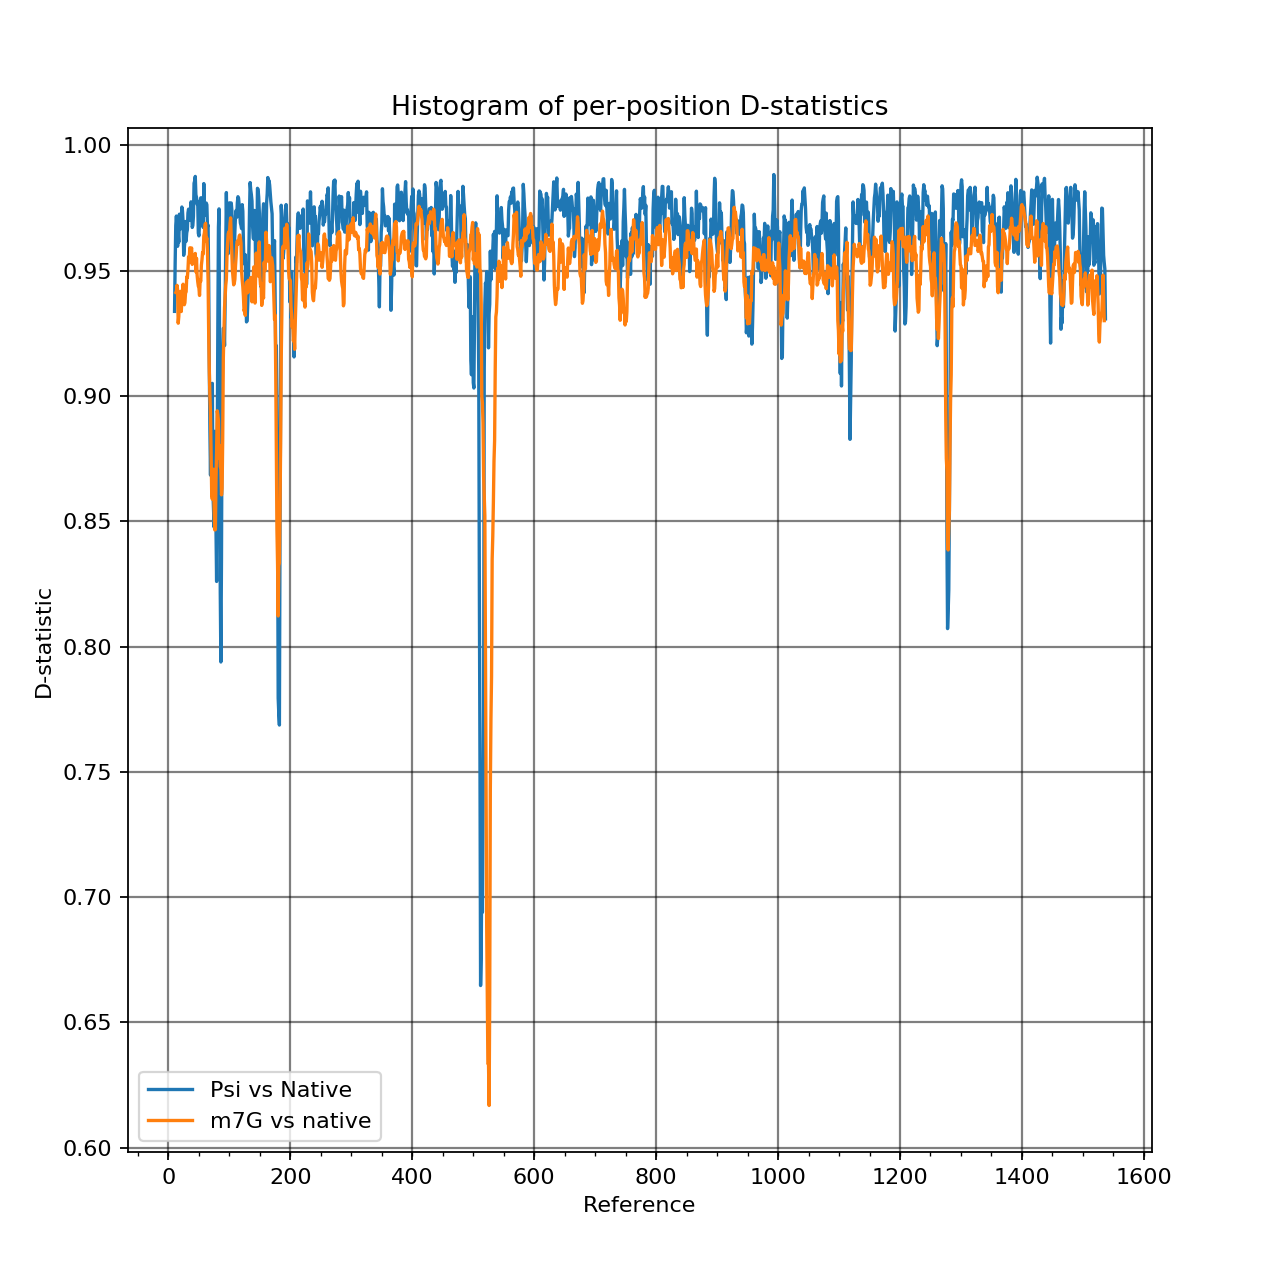

In [50]:
stats_files = [psi_vs_native, m7g_vs_native]
labels = ["Psi vs Native", "m7G vs native"]
save_fig_path = None

title = "Histogram of per-position D-statistics"
y_label = "Reference"

fig = plt.figure(figsize=(8, 8))
panel1 = plt.axes([0.1, 0.1, .8, .8])
panel1.set_xlabel("Reference")
panel1.set_ylabel("D-statistic")
panel1.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)

panel1.set_title(label=title)

for i in range(len(stats_files)):
    assert os.path.exists(stats_files[i])
    ts = tombo_stats.TomboStats(stats_files[i])
    for contig in ts:
        if contig[0] == "ecoli_MRE600" and contig[1] == "+":
            all_data = contig[4]
            panel1.plot([x[1] for x in all_data], [x[0] for x in all_data], label=labels[i])

panel1.xaxis.set_major_locator(ticker.MultipleLocator(200))
panel1.xaxis.set_minor_locator(ticker.MultipleLocator(50))

panel1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

panel1.legend()

# option to save figure or just show it
if save_fig_path is not None:
    plt.savefig(save_fig_path)


<IPython.core.display.Javascript object>


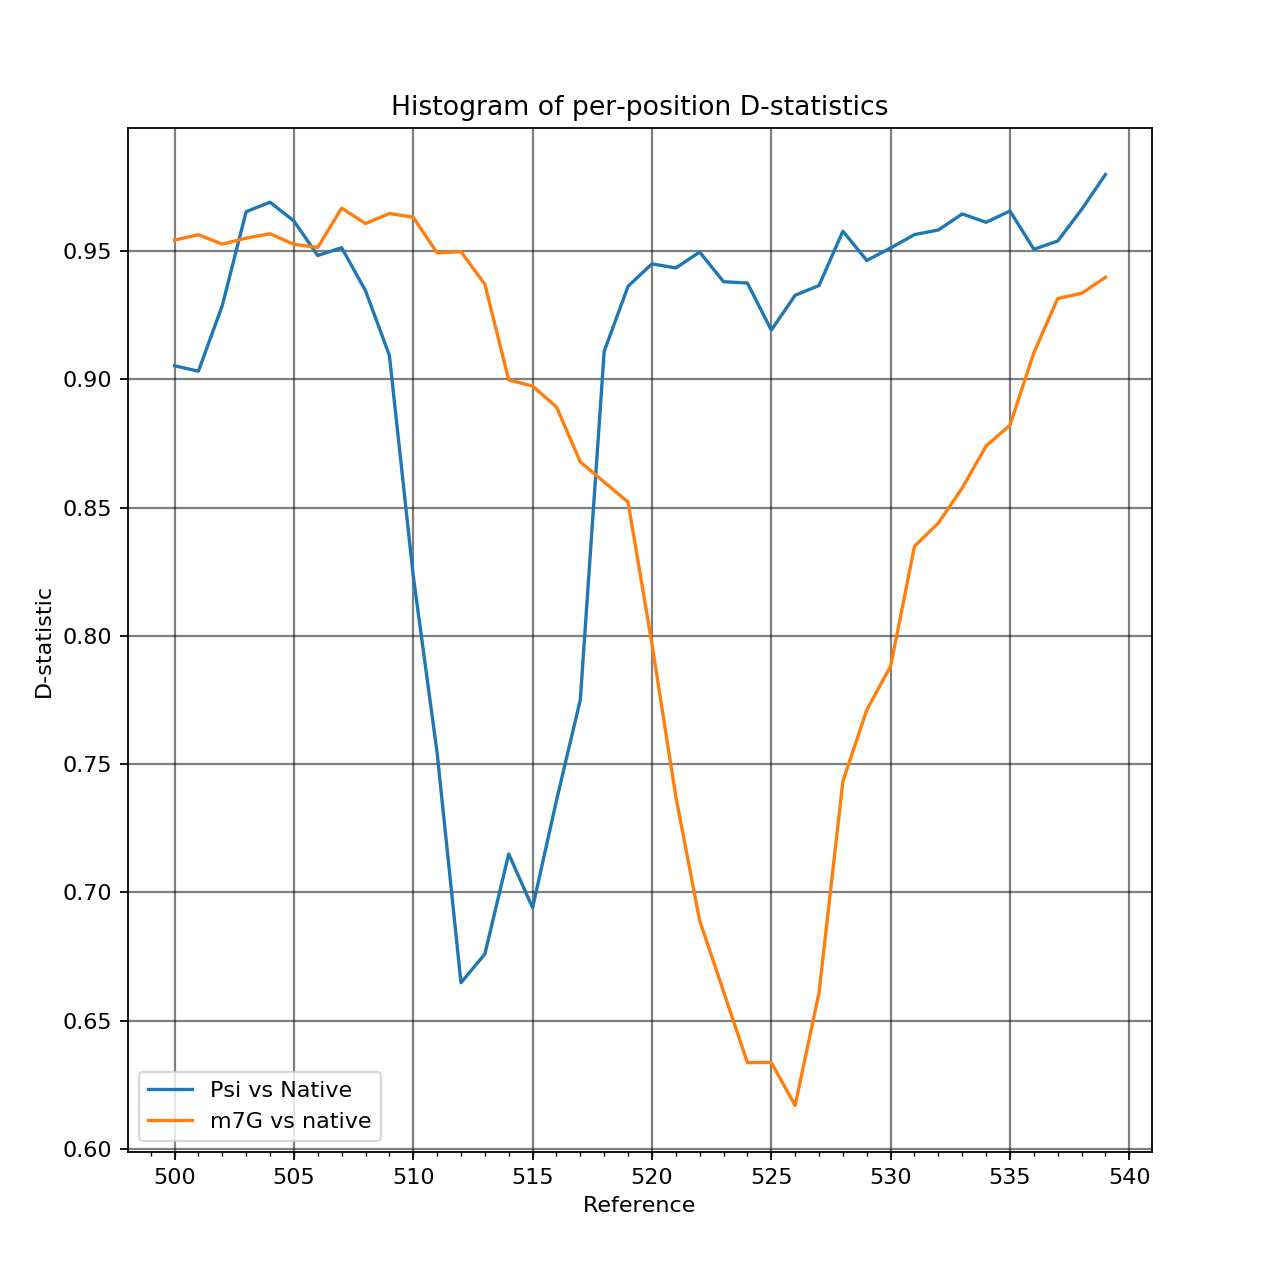

In [52]:
stats_files = [psi_vs_native, m7g_vs_native]
labels = ["Psi vs Native", "m7G vs native"]
save_fig_path = None

max_position = 540
min_position = 500

title = "Histogram of per-position D-statistics"
y_label = "Reference"

fig = plt.figure(figsize=(8, 8))
panel1 = plt.axes([0.1, 0.1, .8, .8])
panel1.set_xlabel("Reference")
panel1.set_ylabel("D-statistic")
panel1.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)

panel1.set_title(label=title)

for i in range(len(stats_files)):
    assert os.path.exists(stats_files[i])
    ts = tombo_stats.TomboStats(stats_files[i])
    for contig in ts:
        if contig[0] == "ecoli_MRE600" and contig[1] == "+":
            all_data = contig[4][np.logical_and(contig[4]["pos"] < max_position, contig[4]["pos"] >= min_position)]
            panel1.plot([x[1] for x in all_data], [x[0] for x in all_data], label=labels[i])

panel1.xaxis.set_major_locator(ticker.MultipleLocator(5))
panel1.xaxis.set_minor_locator(ticker.MultipleLocator(1))

panel1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

panel1.legend()

# option to save figure or just show it
if save_fig_path is not None:
    plt.savefig(save_fig_path)
